# 11 - Escore de Propensão

## A Psicologia do Crescimento

O campo da psicologia positiva estuda quais comportamentos humanos conduzem a uma vida plena. Pode-se pensar nisso como a interseção entre livros de autoajuda e a rigorosidade acadêmica das estatísticas. Uma das descobertas famosas da psicologia positiva é a **Mentalidade de Crescimento**. A ideia é que as pessoas podem ter uma mentalidade fixa ou uma mentalidade de crescimento. Se você tem uma mentalidade fixa, acredita que as habilidades são dadas ao nascer ou na infância. Assim, a inteligência é fixa e não pode mudar ao longo da vida. Se você não a tem até agora, não pode adquiri-la. O corolário desse pensamento é que você não deve perder tempo em áreas onde não se destaca, já que nunca aprenderá a lidar com elas. Por outro lado, se você tem uma mentalidade de crescimento, acredita que a inteligência pode ser desenvolvida. A consequência direta disso é que você encara o fracasso não como falta de tenacidade, mas como parte de um processo de aprendizado. 

Não quero debater qual dessas mentalidades é a correta (embora provavelmente esteja em algum lugar no meio). Para nosso propósito, isso não importa muito. O que importa é que os psicólogos descobriram que pessoas que têm uma mentalidade de crescimento tendem a se sair melhor na vida. Elas têm mais probabilidade de alcançar o que se propuseram a fazer.

Tão versados quanto somos em inferência causal, aprendemos a encarar essas afirmações com ceticismo. Será que uma mentalidade de crescimento faz com que as pessoas alcancem mais? Ou é simplesmente o caso de que pessoas que alcançam mais têm propensão a desenvolver uma mentalidade de crescimento como resultado de seu sucesso? Quem veio primeiro, o ovo ou a galinha? Na notação de resultados potenciais, temos motivos para acreditar que há viés nessas afirmações. $Y_0|T=1$ provavelmente é maior do que $Y_0|T=0$, o que significa que aqueles com uma mentalidade de crescimento teriam alcançado mais mesmo se tivessem uma mentalidade fixa.

Para resolver a questão, os pesquisadores projetaram o [The National Study of Learning Mindsets](https://mindsetscholarsnetwork.org/about-the-network/current-initatives/national-mindset-study/#). Trata-se de um estudo randomizado conduzido em escolas públicas de ensino médio nos Estados Unidos, com o objetivo de descobrir o impacto de uma mentalidade de crescimento. O funcionamento é o seguinte: os alunos recebem da escola um seminário para instilar neles uma mentalidade de crescimento. Em seguida, acompanham os alunos durante seus anos universitários para medir seu desempenho acadêmico. Essa medição é compilada em uma pontuação de realizações e padronizada. Os dados reais deste estudo não estão disponíveis publicamente para preservar a privacidade dos alunos. No entanto, temos um conjunto de dados simulados com as mesmas propriedades estatísticas fornecidas por [Athey e Wager](https://arxiv.org/pdf/1902.07409.pdf), então usaremos isso no lugar.

In [1]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
from matplotlib import style
from matplotlib import pyplot as plt
import seaborn as sns
import statsmodels.formula.api as smf
from causalinference import CausalModel

import graphviz as gr

%matplotlib inline

style.use("fivethirtyeight")
pd.set_option("display.max_columns", 6)

Além das variáveis tratadas e de resultado, o estudo também registrou algumas outras características:

* schoolid: identificador da escola do aluno;
* success_expect: expectativas auto-relatadas para o sucesso no futuro, uma proxy para realizações anteriores, medida antes da atribuição aleatória;
* ethnicity: variável categórica para raça/etnia do aluno;
* gender: variável categórica para o gênero identificado pelo aluno;
* frst_in_family: variável categórica para o status de primeira geração do aluno, ou seja, o primeiro da família a cursar faculdade;
* school_urbanicity: variável categórica ao nível da escola para urbanidade da escola, ou seja, rural, suburbana, etc;
* school_mindset: média ao nível da escola das mentalidades fixas dos alunos, relatada antes da atribuição aleatória, padronizada;
* school_achievement: nível de realização escolar, medido por notas em testes e preparação para a faculdade das quatro turmas de alunos anteriores, padronizado;
* school_ethnic_minority: composição racial/étnica da escola, ou seja, percentual do corpo discente que é Negro, Latino ou Nativo Americano, padronizado;
* school_poverty: concentração de pobreza na escola, ou seja, percentual de alunos provenientes de famílias cujas rendas estão abaixo da linha federal de pobreza, padronizado;
* school_size: número total de alunos em todos os quatro níveis de série na escola, padronizado.

In [2]:
data = pd.read_csv("./data/learning_mindset.csv")
data.sample(5, random_state=5)

schoolid  intervention  achievement_score  ...  school_ethnic_minority  \
259         73             1           1.480828  ...               -0.515202   
3435        76             0          -0.987277  ...               -1.310927   
9963         4             0          -0.152340  ...                0.875012   
4488        67             0           0.358336  ...                0.315755   
2637        16             1           1.360920  ...               -0.033161   

      school_poverty  school_size  
259        -0.169849     0.173954  
3435        0.224077    -0.426757  
9963       -0.724801     0.761781  
4488        0.054586     1.862187  
2637       -0.982274     1.591641  

[5 rows x 13 columns]

Embora o estudo tenha sido randomizado, não parece ser o caso de que esses dados estão livres de confundidores. Se observarmos as características adicionais, notaremos que elas variam sistematicamente entre o tratamento e o controle. Uma possível razão para isso é que a variável de tratamento é medida pela participação do aluno no seminário. Portanto, embora a oportunidade de participar tenha sido aleatória, a participação em si não é. Estamos lidando aqui com um caso de cumprimento parcial. Uma evidência disso é como a expectativa de sucesso auto-relatada pelo aluno está correlacionada com a participação no seminário. Alunos com expectativas de sucesso mais altas têm mais probabilidade de terem participado do seminário de mentalidade de crescimento.

In [3]:
data.groupby("success_expect")["intervention"].mean()

success_expect
1    0.271739
2    0.265957
3    0.294118
4    0.271617
5    0.311070
6    0.354287
7    0.362319
Name: intervention, dtype: float64

Ainda assim, vamos ver como se parece a diferença nas médias $E[Y|T=1] - E[Y|T=0]$. Isso será uma linha de base útil para comparação.

In [4]:
smf.ols("achievement_score ~ intervention", data=data).fit().summary().tables[1]

<class 'statsmodels.iolib.table.SimpleTable'>

Ao simplesmente comparar aqueles com e sem a intervenção, podemos ver que os tratados têm uma pontuação de realizações que é, em média, 0,3185 (0,4723 - 0,1538) mais alta do que a pontuação média (que é zero, já que a pontuação é padronizada). Mas isso é grande ou pequeno? Eu sei que interpretar resultados padronizados pode ser desafiador, mas me acompanhe por um momento. Acredito que vale a pena passar por isso, pois não será a última vez que você encontrará pontuações padronizadas.
 
A variável de resultado sendo padronizada significa que é medida em desvios padrão. Portanto, os tratados estão 0,3185 desvios acima dos não tratados. Isso é o que isso significa. Quanto a saber se isso é pequeno ou grande, vamos lembrar algumas coisas sobre a distribuição normal. Sabemos que 95% da sua massa está entre 2 desvios padrão, deixando 2,5% em uma cauda e 2,5% em outra. Isso também significa que se alguém estiver 2 desvios padrão acima da média, 97,5% (95% mais a cauda esquerda de 2,5%) de todos os indivíduos estão abaixo dessa pessoa. Ao olhar para a CDF normal, também sabemos que cerca de 85% de sua massa está abaixo de 1 desvio padrão e que 70% de sua massa está abaixo de 0,5 desvio padrão. Como o grupo tratado tem uma pontuação padronizada média de cerca de 0,5, isso significa que eles estão acima de 70% em termos de realizações individuais. Ou, em outras palavras, estão no top 30% dos que alcançam mais. Eis como isso se parece em uma imagem.

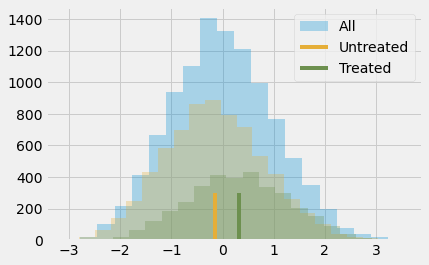

In [5]:
plt.hist(data["achievement_score"], bins=20, alpha=0.3, label="All")
plt.hist(data.query("intervention==0")["achievement_score"], bins=20, alpha=0.3, color="C2")
plt.hist(data.query("intervention==1")["achievement_score"], bins=20, alpha=0.3, color="C3")
plt.vlines(-0.1538, 0, 300, label="Untreated", color="C2")
plt.vlines(-0.1538+0.4723, 0, 300, label="Treated", color="C3")
plt.legend();

Claro, ainda achamos que esse resultado está enviesado. A diferença entre tratados e não tratados provavelmente é menor do que isso, porque acreditamos que o viés é positivo. Já vimos que pessoas mais ambiciosas têm mais disposição para participar do seminário, então provavelmente teriam alcançado mais mesmo que não o tivessem frequentado. Para controlar esse viés, poderíamos usar regressão ou emparelhamento, mas é hora de aprender sobre uma nova técnica.

## Escores de Propensão

O escore de propensão surge da constatação de que você não precisa controlar diretamente os confundidores X para alcançar independência condicional $(Y_1, Y_0) \perp T | X$. Em vez disso, é suficiente controlar por um escore de equilíbrio $E[T|X]$. Esse escore de equilíbrio é frequentemente a probabilidade condicional do tratamento, $P(T|X)$, também chamada de escore de propensão $e(x)$. O escore de propensão faz com que você não precise condicionar sobre a totalidade de X para alcançar independência dos resultados potenciais no tratamento. É suficiente condicionar apenas essa variável única, que é o escore de propensão:

$
(Y_1, Y_0) \perp T | e(x)
$

Existe uma prova formal para explicar por que isso acontece, mas podemos esquecê-la por enquanto e abordar a questão de maneira mais intuitiva. O escore de propensão é a probabilidade condicional de receber o tratamento, certo? Portanto, podemos pensar nele como uma espécie de função que converte X no tratamento T. O escore de propensão cria esse ponto intermediário entre a variável X e o tratamento T. Se mostrarmos isso em um gráfico causal, é assim que ficaria:

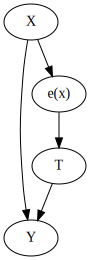

In [6]:
g = gr.Digraph()
g.edge("T", "Y")
g.edge("X", "Y")
g.edge("X", "e(x)")
g.edge("e(x)", "T")
g

Se eu souber o que é e(x), X por si só não me diz nada mais que possa ajudar a aprender o que T seria. Isso significa que controlar por e(x) age da mesma forma que controlar por X diretamente. Pense nisso em termos do nosso programa mental. Tratados e não tratados não são inicialmente comparáveis porque os mais ambiciosos têm mais probabilidade tanto de fazer o tratamento quanto de alcançar mais na vida. No entanto, se eu pegar dois indivíduos, um do tratamento e outro do controle, mas com a mesma probabilidade de receber o tratamento, eles são comparáveis. Pense sobre isso. Se eles tiverem exatamente a mesma probabilidade de receber o tratamento, a única razão pela qual um deles o recebeu e o outro não é pura sorte. Manter o escore de propensão constante age de uma maneira que faz com que os dados se assemelhem muito a randômicos.

Agora que temos a intuição, vamos olhar a prova matemática. Queremos mostrar que $(Y_1, Y_0) \perp T | e(x)$ é equivalente a dizer que

$
E[T|e(x), X] = E[T|e(x)] 
$

Isso simplesmente diz que, uma vez que eu condicione sobre $e(x)$, X não pode me fornecer informações adicionais sobre $T$. A prova disso é bastante peculiar. Vamos mostrar que a equação acima é verdadeira ao convertê-la em uma afirmação trivial. Primeiro, dê uma olhada no lado esquerdo $E[T|e(x), X]$.

$
E[T|e(x), X] = E[T|X] = e(x)
$

Usamos o fato de que $e(x)$ é apenas uma função de X, então condicionar sobre ele não fornece informações adicionais após termos condicionado sobre X. Em seguida, usamos a definição do escore de propensão $E[T|X]$.

Para o lado direito, usaremos a lei das expectativas iteradas $E[A] = E[E[A|B]]$. Essa lei diz que podemos calcular o valor esperado de A olhando para o valor de A decomposto por B e, em seguida, fazendo a média disso.

$
E[T|e(x)] = E[E[T|e(x),X]|e(x)] = E[e(x)|e(x)] = e(x)
$

A primeira igualdade vem da lei das expectativas iteradas. A segunda vem do que descobrimos ao lidar com o lado esquerdo. Como ambos os lados esquerdo e direito são iguais a $e(x)$, essa equação é trivialmente verdadeira.

## Propensity Weighting

![img](./data/img/ps/balance.png)

Certo, obtivemos o escore de propensão. E agora? Como eu disse, tudo o que precisamos fazer é condicionar sobre ele. Por exemplo, poderíamos executar uma regressão linear que condiciona apenas sobre o escore de propensão, em vez de todas as variáveis X. Por enquanto, vamos examinar uma técnica que usa apenas o escore de propensão e mais nada. A ideia é escrever a diferença condicional nas médias com o escore de propensão.

$
E[Y|X,T=1]-E[Y|X,T=0] = E\bigg[\dfrac{Y}{e(x)}|X,T=1\bigg]P(T) - E\bigg[\dfrac{Y}{(1-e(x))}|X,T=0\bigg](1-P(T))
$

Podemos simplificar isso ainda mais, mas vamos examinar dessa forma porque nos dá uma boa intuição do que o escore de propensão está fazendo. O primeiro termo está estimando $Y_1$. Ele está pegando todos os tratados e escalonando-os pela probabilidade inversa de tratamento. O que isso faz é dar um peso alto àqueles com probabilidade muito baixa de tratamento. Isso faz sentido, certo? Se alguém tem uma baixa probabilidade de tratamento, esse indivíduo parece não tratado. No entanto, esse mesmo indivíduo foi tratado. Isso deve ser interessante. Temos um tratado que parece não tratado, então daremos a essa entidade um peso alto. Isso cria uma população com o mesmo tamanho que a original, mas onde todos são tratados. Pelo mesmo raciocínio, o outro termo analisa os não tratados e dá um peso alto àqueles que parecem tratados. Este estimador é chamado de Ponderação pela Probabilidade Inversa de Tratamento (IPTW em inglês), pois escalona cada unidade pela probabilidade inversa do tratamento que recebeu.

Numa imagem, é assim que essa ponderação funciona.

![img](./data/img/ps/iptw.png)

O gráfico superior esquerdo mostra os dados originais. Os pontos azuis são os não tratados e os pontos vermelhos são os tratados. O gráfico inferior mostra o escore de propensão $e(x)$. Observe como ele está entre 0 e 1 e cresce à medida que X aumenta. Finalmente, o gráfico superior direito é os dados após a ponderação. Observe como os pontos vermelhos (tratados) que estão mais à esquerda (menor escore de propensão) têm um peso maior. Da mesma forma, os pontos azuis que estão à direita também têm um peso maior.

Agora que temos a intuição, podemos simplificar os termos acima para

$$
\begin{align}
E[Y|X,T=1]-E[Y|X,T=0] &= E\bigg[\dfrac{Y}{e(x)}|X,T=1\bigg]P(T) - E\bigg[\dfrac{Y}{(1-e(x))}|X,T=0\bigg](1-P(T)) \\
&=E\bigg[\dfrac{YT}{e(x)}\bigg|X\bigg] - E\bigg[\dfrac{Y(1-T)}{(1-e(x))}\bigg|X\bigg] \\
&=E\bigg[\dfrac{YT}{e(x)} - \dfrac{Y(1-T)}{(1-e(x))}\bigg|X\bigg] \\
&=E\bigg[Y\dfrac{T(1-e(x)) - e(x)(1-T)}{e(x)(1-e(x))}\bigg|X\bigg] \\
&=E\bigg[Y \dfrac{T-e(x)}{e(x)(1-e(x))}\bigg|X\bigg]
\end{align}
$$


o que, se integrarmos sobre X, torna-se nosso estimador de ponderação pelo escore de propensão.

$
E\bigg[Y \dfrac{T-e(x)}{e(x)(1-e(x))}\bigg]
$

Observe que este estimador requer que $e(x)$ e $1-e(x)$ sejam maiores que zero. Em outras palavras, isso significa que todos precisam ter pelo menos alguma chance de receber o tratamento e de não recebê-lo. Outra forma de declarar isso é que as distribuições tratada e não tratada precisam se sobrepor. Esta é a **pressuposição de positividade** na inferência causal. Também faz sentido intuitivo. Se as distribuições tratada e não tratada não se sobrepõem, significa que são muito diferentes, e não poderei extrapolar o efeito de um grupo para o outro. Essa extrapolação não é impossível (a regressão a faz), mas é muito perigosa. É como testar um novo medicamento em um experimento onde apenas homens recebem o tratamento e depois assumir que as mulheres responderão igualmente bem.

## Estimação do Escore de Propensão

Em um mundo ideal, teríamos o verdadeiro escore de propensão $e(x)$. No entanto, na prática, o mecanismo que atribui o tratamento é desconhecido, e precisamos substituir o verdadeiro escore de propensão por uma estimativa dele $\hat{e}(x)$. Uma maneira comum de fazer isso é usar regressão logística, mas outros métodos de aprendizado de máquina, como *gradient boosting*, também podem ser usados (embora exija algumas etapas adicionais para evitar o *overfitting*).

Aqui, vou me ater à regressão logística. Isso significa que terei que converter as características categóricas no conjunto de dados em variáveis dummy.

In [7]:
categ = ["ethnicity", "gender", "school_urbanicity"]
cont = ["school_mindset", "school_achievement", "school_ethnic_minority", "school_poverty", "school_size"]

data_with_categ = pd.concat([
    data.drop(columns=categ), # dataset without the categorical features
    pd.get_dummies(data[categ], columns=categ, drop_first=False)# categorical features converted to dummies
], axis=1)

print(data_with_categ.shape)

(10391, 32)


Agora, vamos estimar o escore de propensão usando regressão logística.

In [8]:
from sklearn.linear_model import LogisticRegression

T = 'intervention'
Y = 'achievement_score'
X = data_with_categ.columns.drop(['schoolid', T, Y])

ps_model = LogisticRegression(C=1e6).fit(data_with_categ[X], data_with_categ[T])

data_ps = data.assign(propensity_score=ps_model.predict_proba(data_with_categ[X])[:, 1])

data_ps[["intervention", "achievement_score", "propensity_score"]].head()

intervention  achievement_score  propensity_score
0             1           0.277359          0.315486
1             1          -0.449646          0.263801
2             1           0.769703          0.344024
3             1          -0.121763          0.344024
4             1           1.526147          0.367784

Primeiro, podemos garantir que a ponderação pelo escore de propensão realmente reconstrói uma população em que todos são tratados. Ao produzir pesos $1/e(x)$, ele cria a população onde todos são tratados, e ao fornecer os pesos $1/(1-e(x))$, cria a população onde todos são não tratados.

In [9]:
weight_t = 1/data_ps.query("intervention==1")["propensity_score"]
weight_nt = 1/(1-data_ps.query("intervention==0")["propensity_score"])
print("Original Sample Size", data.shape[0])
print("Treated Population Sample Size", sum(weight_t))
print("Untreated Population Sample Size", sum(weight_nt))

Original Sample Size 10391
Treated Population Sample Size 10388.565115367259
Untreated Population Sample Size 10391.440761283782


Também podemos usar o escore de propensão para encontrar evidências de confusão. Se uma segmentação da população tiver um escore de propensão mais alto do que outra, significa que algo que não é aleatório está causando o tratamento. Se esse mesmo fator também estiver causando o resultado, temos confusão. No nosso caso, podemos ver que os alunos que relataram ser mais ambiciosos também têm uma probabilidade maior de participar do seminário de mentalidade de crescimento.

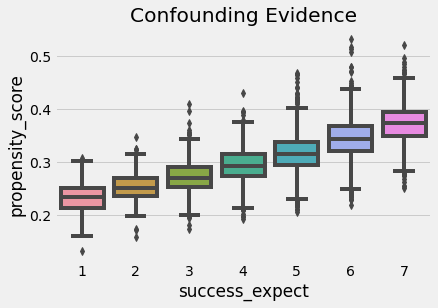

In [10]:
sns.boxplot(x="success_expect", y="propensity_score", data=data_ps)
plt.title("Confounding Evidence");

Também precisamos verificar se há sobreposição entre a população tratada e não tratada. Para fazer isso, podemos observar a distribuição empírica do escore de propensão nos não tratados e nos tratados. Ao olhar para a imagem abaixo, podemos ver que ninguém tem um escore de propensão de zero e que mesmo nas regiões mais baixas do escore de propensão podemos encontrar tanto indivíduos tratados quanto não tratados. Isso é o que chamamos de uma população tratada e não tratada bem balanceada.

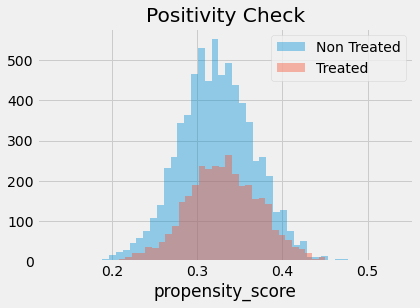

In [11]:
sns.distplot(data_ps.query("intervention==0")["propensity_score"], kde=False, label="Non Treated")
sns.distplot(data_ps.query("intervention==1")["propensity_score"], kde=False, label="Treated")
plt.title("Positivity Check")
plt.legend();

Finalmente, podemos usar nosso estimador de ponderação pelo escore de propensão para estimar o efeito médio do tratamento.

In [12]:
weight = ((data_ps["intervention"]-data_ps["propensity_score"]) /
          (data_ps["propensity_score"]*(1-data_ps["propensity_score"])))

y1 = sum(data_ps.query("intervention==1")["achievement_score"]*weight_t) / len(data)
y0 = sum(data_ps.query("intervention==0")["achievement_score"]*weight_nt) / len(data)

ate = np.mean(weight * data_ps["achievement_score"])

print("Y1:", y1)
print("Y0:", y0)
print("ATE", ate)

Y1: 0.2595823130696891
Y0: -0.1289241686986528
ATE 0.38850648176834174


A ponderação pelo escore de propensão está dizendo que devemos esperar que os indivíduos tratados estejam 0,38 desvios padrão acima de seus colegas não tratados, em termos de realizações. Também podemos ver que se ninguém recebeu o tratamento, deveríamos esperar que o nível geral de realizações fosse 0,12 desvio padrão menor do que é agora. Da mesma forma, deveríamos esperar que o nível geral de realizações fosse 0,25 desvio padrão maior se tivéssemos dado o seminário a todos. Contrastando isso com a estimativa de ATE de 0,47 que obtivemos simplesmente comparando tratados e não tratados, isso é evidência de que o viés que temos é de fato positivo e que controlar por X nos dá uma estimativa mais modesta do impacto da mentalidade de crescimento.

## Standard Error

![img](./data/img/ps/bootstrap.png)

Para calcular o erro padrão do estimador IPTW, podemos usar a fórmula da variância de uma média ponderada.

$
\sigma^2_w = \dfrac{\sum_{i=1}^{n}w_i(y_i-\hat{\mu})^2}{\sum_{i=1}^{n}w_i}
$

No entanto, só podemos usar isso se tivermos o verdadeiro escore de propensão. Se estivermos usando a versão estimada, $\hat{P}(x)$, precisamos levar em conta os erros nesse processo de estimação. A maneira mais fácil de fazer isso é realizando um *bootstrapping* do procedimento completo. Isso é alcançado extraíndo amostras com reposição a partir dos dados originais e calculando o ATE como fizemos acima. Em seguida, repetimos esse procedimento várias vezes para obter a distribuição da estimativa do ATE.

In [13]:
from joblib import Parallel, delayed # for parallel processing

# define function that computes the IPTW estimator
def run_ps(df, X, T, y):
    # estimate the propensity score
    ps = LogisticRegression(C=1e6, max_iter=1000).fit(df[X], df[T]).predict_proba(df[X])[:, 1]
    
    weight = (df[T]-ps) / (ps*(1-ps)) # define the weights
    return np.mean(weight * df[y]) # compute the ATE

np.random.seed(88)
# run 1000 bootstrap samples
bootstrap_sample = 1000
ates = Parallel(n_jobs=4)(delayed(run_ps)(data_with_categ.sample(frac=1, replace=True), X, T, Y)
                          for _ in range(bootstrap_sample))
ates = np.array(ates)

O ATE é então a média das amostras de bootstrap. Para obter intervalos de confiança, podemos examinar os quantis da distribuição das amostras de bootstrap. Para o intervalo de confiança de 95%, usamos os percentis 2,5 e 97,5.

In [14]:
print(f"ATE: {ates.mean()}")
print(f"95% C.I.: {(np.percentile(ates, 2.5), np.percentile(ates, 97.5))}")

ATE: 0.3877446247220722
95% C.I.: (0.3545132414290843, 0.41992560836402076)


Também podemos ter uma visualização de como se parecem as amostras de bootstrap, junto com os intervalos de confiança.

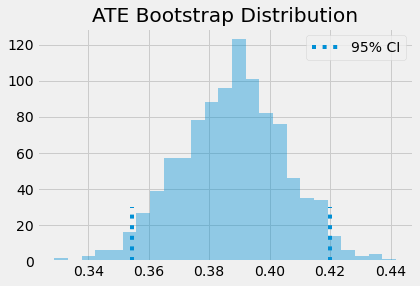

In [15]:
sns.distplot(ates, kde=False)
plt.vlines(np.percentile(ates, 2.5), 0, 30, linestyles="dotted")
plt.vlines(np.percentile(ates, 97.5), 0, 30, linestyles="dotted", label="95% CI")
plt.title("ATE Bootstrap Distribution")
plt.legend();

## Problemas Comuns com o Escore de Propensão

Como cientista de dados, sei que pode ser tentador usar todo o poder do conjunto de ferramentas de aprendizado de máquina para tornar a estimação do escore de propensão o mais precisa possível. Você pode facilmente se perder na otimização de todas as AUC, validação cruzada e ajuste bayesiano de hiperparâmetros. Agora, não estou dizendo que você não deveria fazer isso. Na verdade, toda a teoria sobre o escore de propensão e aprendizado de máquina é muito recente, então há muitas coisas que ainda não sabemos. Mas vale a pena entender algo primeiro.

A primeira coisa é que a qualidade preditiva do escore de propensão não se traduz em suas propriedades de equilíbrio. Vindo do campo de aprendizado de máquina, um dos aspectos mais desafiadores ao se familiarizar com a inferência causal é abandonar a ideia de tratar tudo como um problema de previsão. Na verdade, maximizar o poder de previsão do escore de propensão pode até prejudicar o objetivo de inferência causal. **O escore de propensão não precisa prever muito bem o tratamento. Ele só precisa incluir todas as variáveis confundidoras**. Se incluirmos variáveis que são muito boas em prever o tratamento, mas não têm relevância para o resultado, isso realmente aumentará a variância do estimador do escore de propensão. Isso é semelhante ao problema que a regressão linear enfrenta quando incluímos variáveis correlacionadas com o tratamento, mas não com o resultado.

![img](./data/img/ps/ml-trap.png)

Para enxergar isso, considere o seguinte exemplo (adaptado do livro de Hernán). Você tem 2 escolas, uma delas aplica o seminário de mentalidade de crescimento a 99% de seus alunos e a outra a 1%. Suponha que as escolas não tenham impacto no efeito do tratamento (exceto através do tratamento), então não é necessário controlar isso. Se você adicionar a variável da escola ao modelo de escore de propensão, ela terá um poder preditivo muito alto. No entanto, por acaso, poderíamos acabar com uma amostra onde todos na escola A receberam o tratamento, levando a um escore de propensão de 1 para essa escola, o que resultaria em uma variância infinita. Este é um exemplo extremo, mas vamos ver como funcionaria com dados simulados.

In [16]:
np.random.seed(42)
school_a = pd.DataFrame(dict(T=np.random.binomial(1, .99, 400), school=0, intercept=1))
school_b = pd.DataFrame(dict(T=np.random.binomial(1, .01, 400), school=1, intercept=1))
ex_data = pd.concat([school_a, school_b]).assign(y = lambda d: np.random.normal(1 + 0.1 * d["T"]))
ex_data.head()

T  school  intercept         y
0  1       0          1  0.309526
1  1       0          1  1.571468
2  1       0          1  2.982024
3  1       0          1  2.445420
4  1       0          1  2.693187

Tendo simulado esses dados, executamos a inicialização com o algoritmo do Escore de Propensão duas vezes. Na primeira, incluímos a escola como uma variável no modelo do escore de propensão. Na segunda vez, não incluímos a escola no modelo.

In [17]:
ate_w_f = np.array([run_ps(ex_data.sample(frac=1, replace=True), ["school"], "T", "y") for _ in range(500)])
ate_wo_f = np.array([run_ps(ex_data.sample(frac=1, replace=True), ["intercept"], "T", "y") for _ in range(500)])

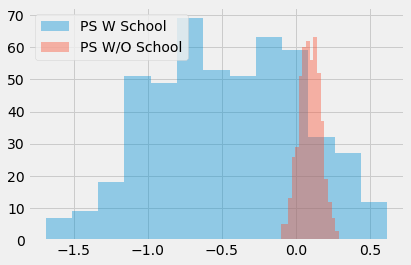

In [18]:
sns.distplot(ate_w_f, kde=False, label="PS W School")
sns.distplot(ate_wo_f, kde=False, label="PS W/O School")
plt.legend();

Como você pode ver, o estimador do escore de propensão que adiciona a variável escola tem uma variância enorme, enquanto o que não a inclui é muito mais comportado. Além disso, como a escola não é um confundidor, o modelo sem ela também não é enviesado. Como eu disse, simplesmente prever o tratamento não é o objetivo. Na verdade, precisamos construir a previsão de uma maneira que controle a confusão, não de uma maneira para prever o tratamento.

Isso leva a outro problema frequentemente encontrado em métodos de escore de propensão. No nosso caso da mentalidade, os dados acabaram sendo muito equilibrados. Mas nem sempre é assim. Em algumas situações, os tratados têm uma probabilidade muito maior de tratamento do que os não tratados e a distribuição do escore de propensão não se sobrepõe muito.

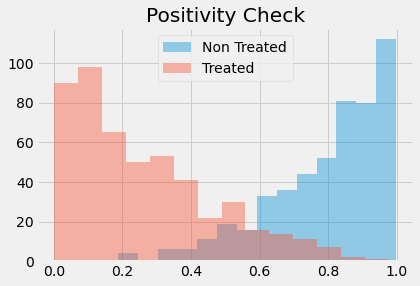

In [19]:
sns.distplot(np.random.beta(4,1,500), kde=False, label="Non Treated")
sns.distplot(np.random.beta(1,3,500), kde=False, label="Treated")
plt.title("Positivity Check")
plt.legend();

Se isso acontecer, significa que a positividade não é muito forte. Se um tratado tem um escore de propensão, digamos, de 0,9 e o escore de propensão máximo dos não tratados é 0,7, não teremos nenhum não tratado para comparar com o indivíduo com escore de propensão de 0,9. Essa falta de equilíbrio pode gerar algum viés, porque teremos que extrapolar o efeito do tratamento para regiões desconhecidas. Além disso, entidades com escores de propensão muito altos ou muito baixos têm um peso muito alto, o que aumenta a variância. Como regra geral, você estará em apuros se algum peso for maior que 20 (o que acontece com um não tratado com escore de propensão de 0,95 ou um tratado com escore de propensão de 0,05).

Uma alternativa é limitar o peso a um tamanho máximo de 20. Isso diminuirá a variância, mas na verdade gerará mais viés. Para ser honesto, embora essa seja uma prática comum para reduzir a variância, eu realmente não gosto dela. Você nunca saberá se o viés que você está introduzindo com o corte é demais. Além disso, se as distribuições não se sobrepõem, seus dados provavelmente não são suficientes para tirar uma conclusão causal de qualquer maneira. Para ganhar mais intuição sobre isso, podemos olhar para uma técnica que combina o escore de propensão e o pareamento.

## Emparelhamento pelo Escore de Propensão

Como eu disse antes, você não precisa controlar X quando tem o escore de propensão. Basta controlar por ele. Como tal, você pode pensar no escore de propensão como realizando uma espécie de redução de dimensionalidade no espaço de características. Ele condensa todas as características em X em uma única dimensão de atribuição de tratamento. Por esse motivo, podemos tratar o escore de propensão como uma característica de entrada para outros modelos. Pegue, por exemplo, um modelo de regressão.

In [20]:
smf.ols("achievement_score ~ intervention + propensity_score", data=data_ps).fit().summary().tables[1]

<class 'statsmodels.iolib.table.SimpleTable'>

Se controlarmos pelo escore de propensão, agora estimamos um ATE de 0,39, que é menor que os 0,47 que obtivemos anteriormente com um modelo de regressão sem controlar pelo escore de propensão. Também podemos usar o emparelhamento pelo escore de propensão. Desta vez, em vez de tentar encontrar correspondências que são semelhantes em todas as características X, podemos encontrar correspondências que apenas têm o mesmo escore de propensão.

Isso é uma melhoria significativa em cima do estimador de emparelhamento, pois lida com a maldição da dimensionalidade. Além disso, se uma característica não for importante para a atribuição do tratamento, o modelo de escore de propensão aprenderá isso e dará baixa importância a ela ao ajustar o mecanismo de tratamento. Emparelhar nas características, por outro lado, ainda tentaria encontrar correspondências onde os indivíduos são semelhantes nessa característica não importante.

In [21]:
cm = CausalModel(
    Y=data_ps["achievement_score"].values, 
    D=data_ps["intervention"].values, 
    X=data_ps[["propensity_score"]].values
)

cm.est_via_matching(matches=1, bias_adj=True)

print(cm.estimates)


Treatment Effect Estimates: Matching

                     Est.       S.e.          z      P>|z|      [95% Conf. int.]
--------------------------------------------------------------------------------
           ATE      0.389      0.025     15.579      0.000      0.340      0.438
           ATC      0.382      0.027     13.921      0.000      0.328      0.435
           ATT      0.405      0.027     15.175      0.000      0.353      0.457



Como podemos ver, também obtemos um ATE de 0,38, o que está mais alinhado com o que vimos anteriormente com a ponderação do escore de propensão. Emparelhar pelo escore de propensão também nos dá alguma intuição sobre por que é perigoso ter uma pequena sobreposição no escore de propensão entre tratados e não tratados. Se isso acontecer, a discrepância no emparelhamento pelo escore de propensão será grande, o que levará a viés, como vimos no capítulo sobre emparelhamento.

Uma última palavra de cautela aqui é que os erros padrão acima estão errados, pois não levam em consideração a incerteza na estimativa do escore de propensão. Infelizmente, [o bootstrap não funciona com emparelhamento](https://economics.mit.edu/sites/default/files/publications/ON%20THE%20FAILURE%20OF%20THE%20BOOTSTRAP%20FOR.pdf). Além disso, a teoria acima é tão recente que não há implementações em Python de métodos de escore de propensão com os erros padrão corretos. Por esse motivo, não vemos muitos casos de emparelhamento pelo escore de propensão em Python.

## Conceitos-chave

Aqui, aprendemos que a probabilidade de receber o tratamento é chamada de escore de propensão e que podemos usá-lo como um escore de balanceamento. Isso significa que, se tivermos o escore de propensão, não precisamos controlar diretamente os confundidores. É suficiente controlar o escore de propensão para identificar o efeito causal. Vimos como os escores de propensão atuam como uma redução de dimensionalidade no espaço dos confundidores.

Essas propriedades nos permitiram derivar um estimador de ponderação para inferência causal. Além disso, vimos como o escore de propensão pode ser usado juntamente com outros métodos para controlar o viés de confusão.

Em seguida, analisamos alguns problemas comuns que podem surgir com o escore de propensão e com a inferência causal em geral. O primeiro é quando nos deixamos levar pela tarefa de ajustar o mecanismo de tratamento. Vimos que, de uma maneira bem contra intuitiva (e, portanto, fácil de cometer erros), aumentar o desempenho preditivo do tratamento **não** se traduz em uma melhor estimativa causal, pois pode aumentar a variância.

Por fim, examinamos alguns problemas de extrapolação que podemos enfrentar se não conseguirmos ter uma boa sobreposição entre a distribuição de escore de propensão dos tratados e não tratados.

## Referências

Gosto de pensar nesta série inteira como uma homenagem a Joshua Angrist, Alberto Abadie e Christopher Walters por sua incrível aula de Econometria. A maioria das ideias aqui foram tiradas de suas aulas na *American Economic Association*. Assisti-las é o que está me mantendo são durante este difícil ano de 2020.
* [Cross-Section Econometrics](https://www.aeaweb.org/conference/cont-ed/2017-webcasts)
* [Mastering Mostly Harmless Econometrics](https://www.aeaweb.org/conference/cont-ed/2020-webcasts)

Também gostaria de referenciar os livros incríveis de Angrist. Eles me mostraram que Econometria, ou 'Métricas, como eles chamam, não é apenas extremamente útil, mas também profundamente divertida.

* [Mostly Harmless Econometrics](https://www.mostlyharmlesseconometrics.com/)
* [Mastering 'Metrics](https://www.masteringmetrics.com/)

Finalmente, gostaria de referenciar o livro de Miguel Hernan e Jamie Robins. Tem sido meu fiel companheiro nas questões mais espinhosas de inferência causal que tive que responder.

* [Causal Inference Book](https://www.hsph.harvard.edu/miguel-hernan/causal-inference-book/)

Os dados que utilizamos foram retirados do artigo [Estimating Treatment Effects with Causal Forests: An Application](https://arxiv.org/pdf/1902.07409.pdf), de Susan Athey e Stefan Wager.

![img](./data/img/poetry.png)

## Contribua

"Inferência Causal para os Corajosos e Verdadeiros" é um material de código aberto sobre inferência causal, a estatística da ciência. Seu objetivo é ser acessível monetariamente e intelectualmente. Ele utiliza apenas software gratuito baseado em Python.
Se você encontrou valor neste livro e deseja apoiá-lo, por favor, vá para o [Patreon](https://www.patreon.com/causal_inference_for_the_brave_and_true). Se você não estiver pronto para contribuir financeiramente, também pode ajudar corrigindo erros, sugerindo edições ou dando feedback sobre trechos que não compreendeu. Acesse o repositório do livro e abra uma issue na [versão em inglês](https://github.com/matheusfacure/python-causality-handbook/issues) ou na [versão em português](https://github.com/rdemarqui/python-causality-handbook-ptbr/issues). Por fim, se você gostou deste conteúdo, compartilhe com outras pessoas que possam achar útil e dê uma estrela no GitHub na [versão em inglês](https://github.com/matheusfacure/python-causality-handbook/stargazers) e na [versão em português](https://github.com/rdemarqui/python-causality-handbook-ptbr/stargazers).

---

<div align="center">
<a href="10-Matching.ipynb"><-- Anterior</a>  
<a href="00-Summary.ipynb">| Sumário |</a>  
<a href="12-Doubly-Robust-Estimation.ipynb">Próximo --></a>  
</div>